In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from econml.dml import CausalForestDML
from econml.grf import CausalForest
from econml.inference import BootstrapInference
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

In [2]:
df = pd.read_csv("selected_data_with_sites.csv")

print("First few rows of the dataset:")
display(df.head())

# print("\nDataset Info:")
# display(df.info())

First few rows of the dataset:


,Ds_Site_Esophagus,Ds_Site_Hypopharynx,Ds_Site_Larynx,Ds_Site_Lip_Oral_Cavity,Ds_Site_Nasal_Cavity,Ds_Site_Oropharynx,Subsite_Base_Of_Tongue,Subsite_Buccal_Mucosa,Subsite_Cervical_Esophagus,Subsite_Floor_Of_Mouth,...,HPV_Positive,HPV_Unknown,Chemo,RT_year,Fx,d_Frac,Total_days_RT,Age,Length_FU,Cause_of_Death_Status
0,0,0,0,0,0,1,0,0,0,0,...,0,0,0,2002,25,2.40,33.0,62.6,1.3,3
1,0,0,1,0,0,0,0,0,0,0,...,0,1,0,2006,20,2.55,26.0,87.3,1.5,3
2,0,0,0,0,0,1,0,0,0,0,...,1,0,0,2009,40,1.60,54.0,49.9,2.1,0
3,0,0,0,0,0,1,0,0,0,0,...,0,0,0,2000,40,1.60,54.0,59.7,9.5,0
4,0,0,1,0,0,0,0,0,0,0,...,0,1,0,1999,20,2.55,26.0,72.3,5.4,0


In [3]:
# dose intensity
df['dose_intensity'] = df['d_Frac'] * df['Fx'] / df['Total_days_RT']

# outcome variable (1 if died from cancer, 0 otherwise)
df['Y'] = (df['Cause_of_Death_Status'] == 1).astype(int)

feature_cols = ['Age', 'Sex', 'Smoking_PY', 'Stage_numeric', 
               'HPV_Positive', 'HPV_Unknown', 'Chemo', 'RT_year']

X = df[feature_cols].copy()

# standardize numeric features and dose intensity
scaler = StandardScaler()
numeric_cols = ['Age', 'Smoking_PY', 'RT_year']
X[numeric_cols] = scaler.fit_transform(X[numeric_cols])

T = df['dose_intensity'].values.reshape(-1, 1)
T_scaled = scaler.fit_transform(T)

print("Features prepared. Shape of X:", X.shape)

Features prepared. Shape of X: (2651, 8)


When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.
SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.


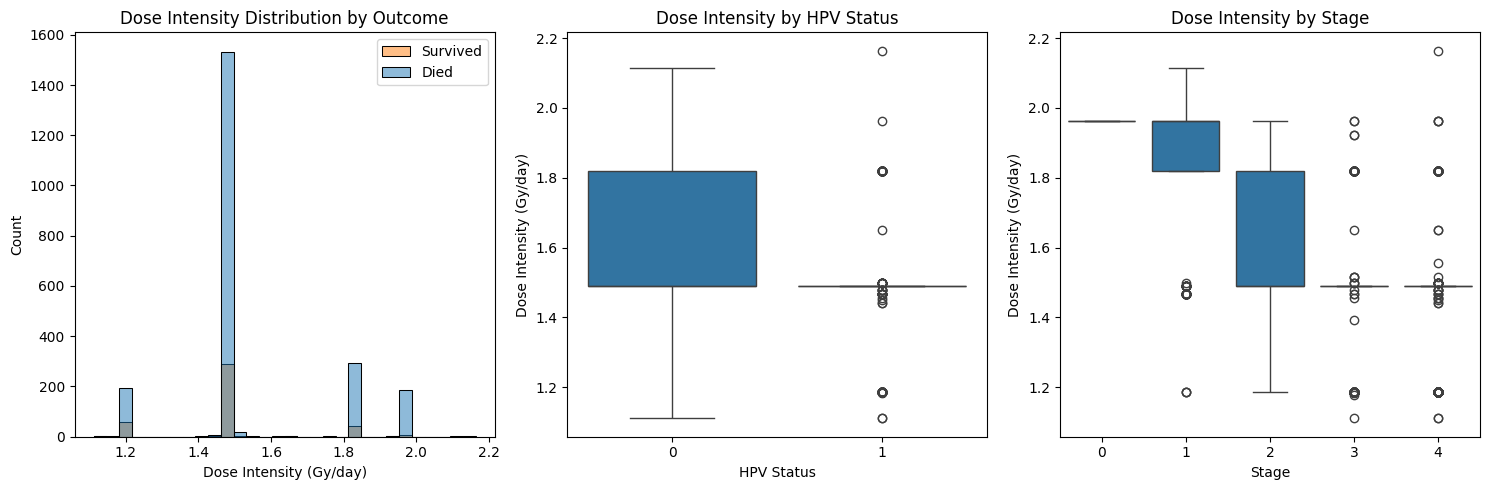

In [4]:
plt.figure(figsize=(15, 5))

# Plot 1: Dose intensity distribution
plt.subplot(1, 3, 1)
sns.histplot(data=df, x='dose_intensity', hue='Y', bins=30)
plt.title('Dose Intensity Distribution by Outcome')
plt.xlabel('Dose Intensity (Gy/day)')
plt.legend(['Survived', 'Died'])

# Plot 2: Dose by HPV status
plt.subplot(1, 3, 2)
sns.boxplot(data=df, x='HPV_Positive', y='dose_intensity')
plt.title('Dose Intensity by HPV Status')
plt.ylabel('Dose Intensity (Gy/day)')
plt.xlabel('HPV Status')

# Plot 3: Dose by Stage
plt.subplot(1, 3, 3)
sns.boxplot(data=df, x='Stage_numeric', y='dose_intensity')
plt.title('Dose Intensity by Stage')
plt.ylabel('Dose Intensity (Gy/day)')
plt.xlabel('Stage')

plt.tight_layout()
plt.show()

In [5]:
# more baseline characteristics
baseline_stats = pd.DataFrame({
    'Mean': df[['Age', 'Smoking_PY', 'dose_intensity']].mean(),
    'SD': df[['Age', 'Smoking_PY', 'dose_intensity']].std(),
    'Min': df[['Age', 'Smoking_PY', 'dose_intensity']].min(),
    'Max': df[['Age', 'Smoking_PY', 'dose_intensity']].max()
})

categorical_stats = pd.DataFrame({
    'Count': [
        df['Sex'].value_counts(),
        df['HPV_Positive'].value_counts(),
        df['Chemo'].value_counts(),
        df['Stage_numeric'].value_counts()
    ]
}).T

print("Continuous Variables Summary:")
display(baseline_stats)
print("\nCategorical Variables Summary:")
display(categorical_stats)


Continuous Variables Summary:


,Mean,SD,Min,Max
Age,63.493889,10.697731,22.300000,90.000000
Smoking_PY,27.615429,24.678065,0.000000,240.000000
dose_intensity,1.536632,0.193507,1.111111,2.163934



Categorical Variables Summary:


,0,1,2,3
Count,"Sex 1 2158 0 493 Name: count, dtype: int64","HPV_Positive 0 1599 1 1052 Name: count, ...","Chemo 0 1663 1 988 Name: count, dtype: ...",Stage_numeric 4 1561 3 417 2 343 1 ...


In [6]:
cf = CausalForestDML(
    #these are the initial trees that are used to estimate the treatment and outcome models
    model_y=RandomForestRegressor(n_estimators=100), #change this rougly 1/4 of the n_estimators down below
    model_t=RandomForestRegressor(n_estimators=100), 
    n_estimators=2000, #can change this up to 10k, more trees = more accurate but slower
    random_state=42
)
cf.fit(Y=df['Y'], T=T_scaled.ravel(), X=X)

Overall Average Treatment Effect (per SD increase in dose intensity): -0.014
95% CI: (-0.079, 0.050)

Subgroup Analysis Results:
Age_Middle: -0.007 (95% CI: -0.069, 0.055)
Age_Older: -0.015 (95% CI: -0.073, 0.044)
Age_Young: -0.021 (95% CI: -0.093, 0.052)
HPV_0: -0.012 (95% CI: -0.071, 0.047)
HPV_1: -0.017 (95% CI: -0.090, 0.055)
Stage_Advanced: -0.014 (95% CI: -0.089, 0.060)
Stage_Early: -0.015 (95% CI: -0.057, 0.028)
Stage_Intermediate: -0.013 (95% CI: -0.075, 0.049)


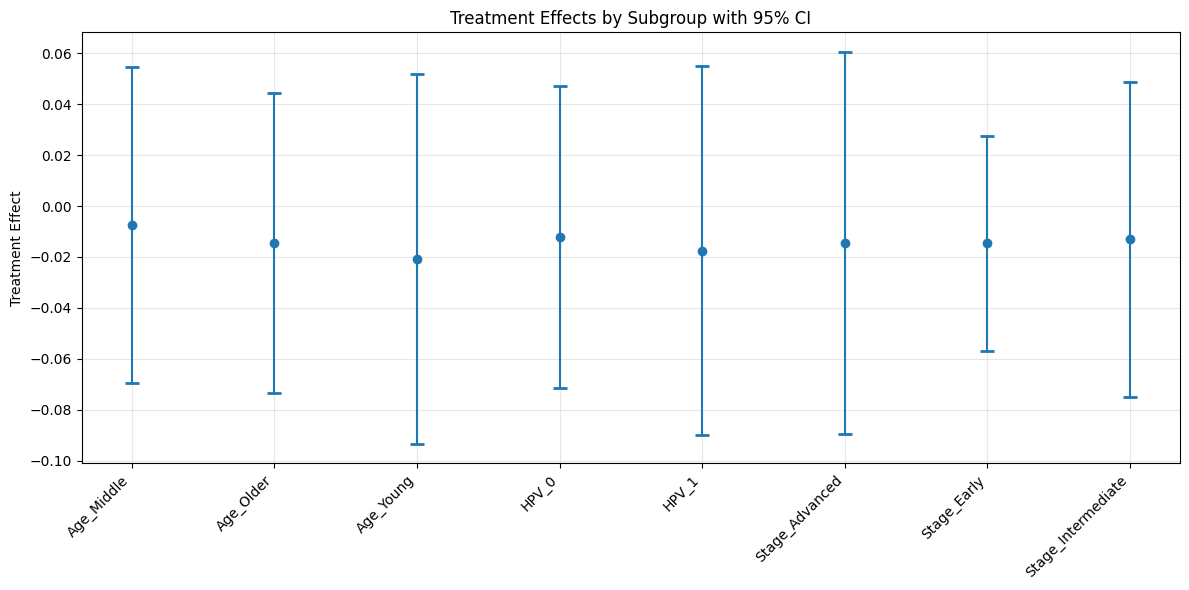

In [7]:
te_pred = cf.effect(X)
ate = np.mean(te_pred)

ate_interval = cf.effect_interval(X=X, alpha=0.05)
ate_lower, ate_upper = np.mean(ate_interval[0]), np.mean(ate_interval[1])

print(f"Overall Average Treatment Effect (per SD increase in dose intensity): {ate:.3f}")
print(f"95% CI: ({ate_lower:.3f}, {ate_upper:.3f})")

# bins for age analysis
num_bins = 3

# subgroup analysis with confidence intervals
subgroup_results = {}

# HPV analysis
for hpv in [0, 1]:
    key = f'HPV_{hpv}'
    mask = df['HPV_Positive'] == hpv
    subgroup_te = te_pred[mask]
    subgroup_results[f'{key}_ate'] = np.mean(subgroup_te)
    
    # confidence intervals for subgroup
    subgroup_interval = cf.effect_interval(X=X.loc[mask], alpha=0.05)
    subgroup_results[f'{key}_ci'] = (
        np.mean(subgroup_interval[0]), 
        np.mean(subgroup_interval[1])
    )

# Stage analysis, I used custom stage grouping
def get_stage_group(stage):
    if stage <= 2:
        return 'Early'
    elif stage == 3:
        return 'Intermediate'
    else:
        return 'Advanced'

stage_bins = df['Stage_numeric'].apply(get_stage_group)
for stage in ['Early', 'Intermediate', 'Advanced']:
    key = f'Stage_{stage}'
    mask = stage_bins == stage
    if mask.any():  # only process if there are cases in this group
        subgroup_te = te_pred[mask]
        subgroup_results[f'{key}_ate'] = np.mean(subgroup_te)
        
        subgroup_interval = cf.effect_interval(X=X.loc[mask], alpha=0.05)
        subgroup_results[f'{key}_ci'] = (
            np.mean(subgroup_interval[0]), 
            np.mean(subgroup_interval[1])
        )

# Age analysis
age_bins = pd.qcut(df['Age'], num_bins, labels=['Young', 'Middle', 'Older'])
for age in age_bins.unique():
    key = f'Age_{age}'
    mask = age_bins == age
    subgroup_te = te_pred[mask]
    subgroup_results[f'{key}_ate'] = np.mean(subgroup_te)
    
    subgroup_interval = cf.effect_interval(X=X.loc[mask], alpha=0.05)
    subgroup_results[f'{key}_ci'] = (
        np.mean(subgroup_interval[0]), 
        np.mean(subgroup_interval[1])
    )

# results
print("\nSubgroup Analysis Results:")
keys = sorted({k.rsplit('_', 1)[0] for k in subgroup_results.keys()})
for key in keys:
    effect = subgroup_results[f'{key}_ate']
    ci = subgroup_results[f'{key}_ci']
    print(f"{key}: {effect:.3f} (95% CI: {ci[0]:.3f}, {ci[1]:.3f})")

plt.figure(figsize=(12, 6))
effects = []
cis = []
labels = []

for key in keys:
    effects.append(subgroup_results[f'{key}_ate'])
    cis.append(subgroup_results[f'{key}_ci'])
    labels.append(key)

effects = np.array(effects)
cis = np.array(cis)

x_pos = np.arange(len(effects))
plt.errorbar(x_pos, effects, 
             yerr=[effects - cis[:, 0], cis[:, 1] - effects],
             fmt='o', capsize=5, capthick=2)

plt.xticks(x_pos, labels, rotation=45, ha='right')
plt.ylabel('Treatment Effect')
plt.title('Treatment Effects by Subgroup with 95% CI')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Subgroup Analysis (effects per SD increase in dose intensity):

HPV Status Analysis:
HPV_0_ate: -0.012 (95% CI: -0.071, 0.047), n=1599
HPV_1_ate: -0.017 (95% CI: -0.090, 0.055), n=1052

Stage Status Analysis:
Stage_0_ate: -0.020 (95% CI: -0.043, 0.003), n=1
Stage_1_ate: -0.013 (95% CI: -0.052, 0.027), n=329
Stage_2_ate: -0.017 (95% CI: -0.061, 0.028), n=343
Stage_3_ate: -0.013 (95% CI: -0.075, 0.049), n=417
Stage_4_ate: -0.014 (95% CI: -0.089, 0.060), n=1561

Chemo Status Analysis:
Chemo_0_ate: -0.013 (95% CI: -0.070, 0.044), n=1663
Chemo_1_ate: -0.017 (95% CI: -0.094, 0.061), n=988


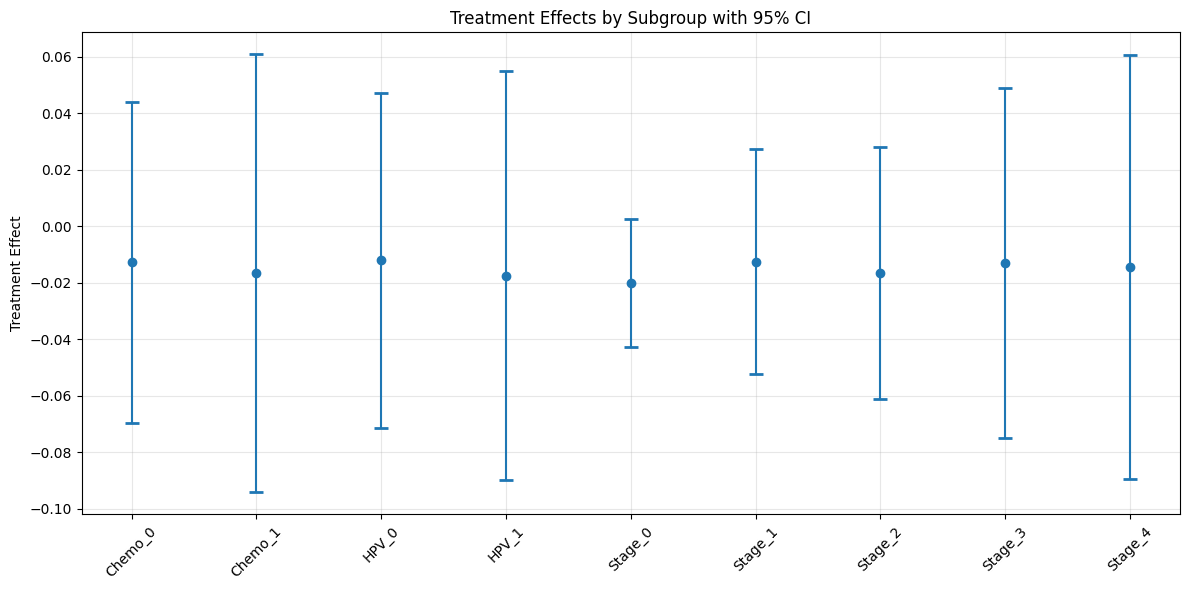

In [8]:
subgroup_results = {}

# HPV Status Analysis
for hpv in [0, 1]:
    mask = df['HPV_Positive'] == hpv
    n_samples = mask.sum()
    subgroup_results[f'HPV_{hpv}_ate'] = np.mean(te_pred[mask])
    subgroup_results[f'HPV_{hpv}_n'] = n_samples
    
    subgroup_interval = cf.effect_interval(X=X.loc[mask], alpha=0.05)
    subgroup_results[f'HPV_{hpv}_ci'] = (
        np.mean(subgroup_interval[0]),
        np.mean(subgroup_interval[1])
    )

# Stage Analysis
for stage in sorted(df['Stage_numeric'].unique()):
    mask = df['Stage_numeric'] == stage
    n_samples = mask.sum()
    subgroup_results[f'Stage_{stage}_ate'] = np.mean(te_pred[mask])
    subgroup_results[f'Stage_{stage}_n'] = n_samples
    
    subgroup_interval = cf.effect_interval(X=X.loc[mask], alpha=0.05)
    subgroup_results[f'Stage_{stage}_ci'] = (
        np.mean(subgroup_interval[0]),
        np.mean(subgroup_interval[1])
    )

# Chemo Analysis
for chemo in [0, 1]:
    mask = df['Chemo'] == chemo
    n_samples = mask.sum()
    subgroup_results[f'Chemo_{chemo}_ate'] = np.mean(te_pred[mask])
    subgroup_results[f'Chemo_{chemo}_n'] = n_samples
    
    subgroup_interval = cf.effect_interval(X=X.loc[mask], alpha=0.05)
    subgroup_results[f'Chemo_{chemo}_ci'] = (
        np.mean(subgroup_interval[0]),
        np.mean(subgroup_interval[1])
    )

# Results
print("\nSubgroup Analysis (effects per SD increase in dose intensity):")
for group in ['HPV', 'Stage', 'Chemo']:
    print(f"\n{group} Status Analysis:")
    for key in sorted([k for k in subgroup_results.keys() if k.startswith(group) and 'ci' not in k and 'n' not in k]):
        effect = subgroup_results[key]
        ci = subgroup_results[f'{key.rsplit("_ate")[0]}_ci']
        n = subgroup_results[f'{key.rsplit("_ate")[0]}_n']
        print(f"{key}: {effect:.3f} (95% CI: {ci[0]:.3f}, {ci[1]:.3f}), n={n}")

plt.figure(figsize=(12, 6))
keys = sorted([k for k in subgroup_results.keys() if k.endswith('ate')])
effects = [subgroup_results[k] for k in keys]
cis = [subgroup_results[k.rsplit('_ate')[0] + '_ci'] for k in keys]

x_pos = np.arange(len(effects))
plt.errorbar(x_pos, effects, 
             yerr=[np.array(effects) - np.array([ci[0] for ci in cis]), 
                   np.array([ci[1] for ci in cis]) - np.array(effects)],
             fmt='o', capsize=5, capthick=2)

plt.xticks(x_pos, [k.rsplit('_ate')[0] for k in keys], rotation=45)
plt.ylabel('Treatment Effect')
plt.title('Treatment Effects by Subgroup with 95% CI')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

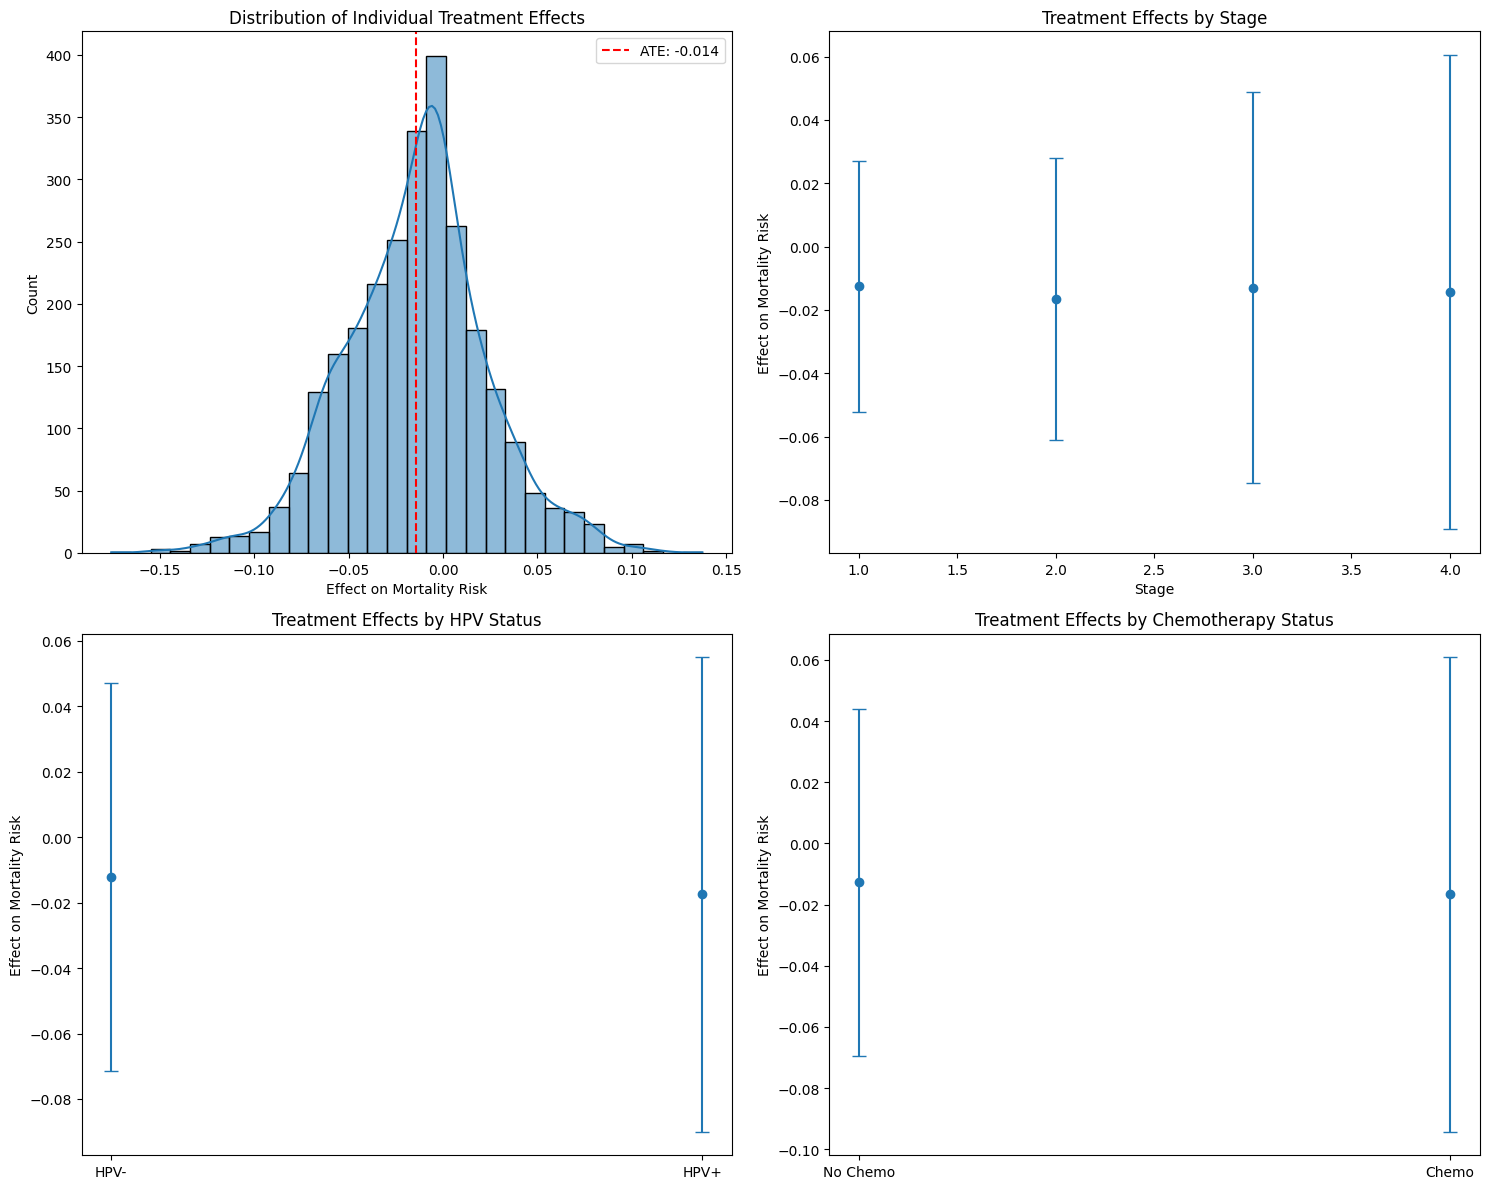

In [9]:
plt.figure(figsize=(15, 12))

# Plot 1: Distribution of treatment effects
plt.subplot(2, 2, 1)
sns.histplot(te_pred, kde=True, bins=30)
plt.axvline(ate, color='red', linestyle='--', label=f'ATE: {ate:.3f}')
plt.title('Distribution of Individual Treatment Effects')
plt.xlabel('Effect on Mortality Risk')
plt.ylabel('Count')
plt.legend()


# Plot 2: Effects by stage with confidence intervals
plt.subplot(2, 2, 2)
stage_data = []
stages = sorted(df['Stage_numeric'].unique())
for stage in stages:
    mask = df['Stage_numeric'] == stage
    if mask.sum() > 1:
        ci = subgroup_results[f'Stage_{stage}_ci']
        stage_data.append({
            'Stage': stage,
            'Effect': np.mean(te_pred[mask]),
            'CI_lower': ci[0],
            'CI_upper': ci[1]
        })
stage_df = pd.DataFrame(stage_data)
    
plt.errorbar(stage_df['Stage'], stage_df['Effect'], 
             yerr=[stage_df['Effect'] - stage_df['CI_lower'], 
                   stage_df['CI_upper'] - stage_df['Effect']],
             fmt='o', capsize=5)
plt.title('Treatment Effects by Stage')
plt.xlabel('Stage')
plt.ylabel('Effect on Mortality Risk')


# Plot 3: Effects by HPV status with confidence intervals
plt.subplot(2, 2, 3)
hpv_effects = pd.DataFrame({
    'HPV Status': ['Negative', 'Positive'],
    'Effect': [subgroup_results['HPV_0_ate'], subgroup_results['HPV_1_ate']],
    'CI_lower': [subgroup_results['HPV_0_ci'][0], subgroup_results['HPV_1_ci'][0]],
    'CI_upper': [subgroup_results['HPV_0_ci'][1], subgroup_results['HPV_1_ci'][1]]
})
plt.errorbar(range(2), hpv_effects['Effect'],
             yerr=[hpv_effects['Effect'] - hpv_effects['CI_lower'],
                   hpv_effects['CI_upper'] - hpv_effects['Effect']],
             fmt='o', capsize=5)
plt.xticks(range(2), ['HPV-', 'HPV+'])
plt.title('Treatment Effects by HPV Status')
plt.ylabel('Effect on Mortality Risk')


# Plot 4: Effects by Chemo status with confidence intervals
plt.subplot(2, 2, 4)
chemo_effects = pd.DataFrame({
    'Chemo': ['No', 'Yes'],
    'Effect': [subgroup_results['Chemo_0_ate'], subgroup_results['Chemo_1_ate']],
    'CI_lower': [subgroup_results['Chemo_0_ci'][0], subgroup_results['Chemo_1_ci'][0]],
    'CI_upper': [subgroup_results['Chemo_0_ci'][1], subgroup_results['Chemo_1_ci'][1]]
})
plt.errorbar(range(2), chemo_effects['Effect'],
             yerr=[chemo_effects['Effect'] - chemo_effects['CI_lower'],
                   chemo_effects['CI_upper'] - chemo_effects['Effect']],
             fmt='o', capsize=5)
plt.xticks(range(2), ['No Chemo', 'Chemo'])
plt.title('Treatment Effects by Chemotherapy Status')
plt.ylabel('Effect on Mortality Risk')

plt.tight_layout()
plt.show()

Feature Importance Values:
         Feature  Importance
0            Age    0.314630
6          Chemo    0.227471
2     Smoking_PY    0.179238
7        RT_year    0.167698
3  Stage_numeric    0.038586
5    HPV_Unknown    0.029762
4   HPV_Positive    0.028412
1            Sex    0.014203


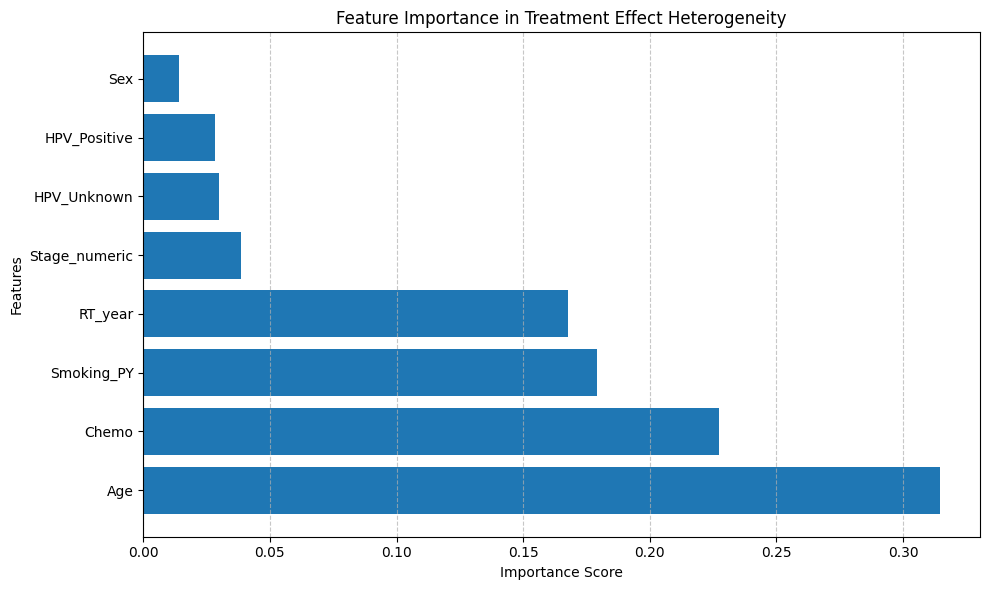

In [10]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': cf.feature_importances_
})

# Sort by importance
feature_importance = feature_importance.sort_values('Importance', ascending=False)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.title('Feature Importance in Treatment Effect Heterogeneity')
plt.xlabel('Importance Score')
plt.ylabel('Features')

plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()

print("Feature Importance Values:")
print(feature_importance)

plt.show()

In [30]:
# results = {
#     'ATE': ate,
#     'CI_lower': ate_interval[0],
#     'CI_upper': ate_interval[1],
#     **subgroup_results
# }

# pd.DataFrame([results]).to_csv('causal_analysis_results.csv', index=False)

# feature_importance.to_csv('feature_importance.csv', index=False)

# individual_effects = pd.DataFrame({
#     'patient_id': df.index,
#     'treatment_effect': te_pred,
#     'dose_intensity': df['dose_intensity'],
#     'HPV_status': df['HPV_Positive'],
#     'Stage': df['Stage_numeric'],
#     'Chemo': df['Chemo']
# })
# individual_effects.to_csv('individual_treatment_effects.csv', index=False)

# print("\nAnalysis complete. Results saved to:")
# print("1. 'causal_analysis_results.csv' - Main results with ATE and subgroup effects")
# print("2. 'feature_importance.csv' - Feature importance analysis")
# print("3. 'individual_treatment_effects.csv' - Patient-level treatment effects")